## Here are the things we will look at :
1. Reading and analyzing data. (Pandas)
2. Normalizing the data. (SkLearn)
3. Converting data to time-series and supervised learning problem.
4. Creating model (Keras)
5. Fine tuning the model (in the next article)
6. Training, predicting and visualizing the result.
7. Tips & tools that I found very helpful (last article of the series)

## 1. Reading and analyzing data

In [1]:
import os, pandas as pd
# Add asset from file system
df_data_1 = pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/ge.us.txt')
df_data_1.head()



,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,0.6277,0.6362,0.6201,0.6201,2575579,0
1,1962-01-03,0.6201,0.6201,0.6122,0.6201,1764749,0
2,1962-01-04,0.6201,0.6201,0.6037,0.6122,2194010,0
3,1962-01-05,0.6122,0.6122,0.5798,0.5957,3255244,0
4,1962-01-08,0.5957,0.5957,0.5716,0.5957,3696430,0


In [2]:
!pip install pandas_datareader

You should consider upgrading via the 'pip install --upgrade pip' command.


## Optionally  you can also use Pandas_datareader to get stock price history

In [95]:
import pandas as pd
from pandas_datareader import data, wb   # Package and modules for importing data; this code may change depending on pandas version
import datetime
 
# We will look at stock prices over the past year, starting at January 1, 2016
start = datetime.datetime(2016,1,1)
end = datetime.date.today()
 
# Let's get Apple stock data; Apple's ticker symbol is AAPL
# First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
microsoft = data.DataReader("MSFT", "yahoo", start, end)
google = data.DataReader("GOOG", "yahoo", start, end)
apple = data.DataReader("AAPL", "yahoo", start, end)
aws = data.DataReader("AMZN", "yahoo", start, end)
 
# Below I create a DataFrame consisting of the adjusted closing price of these stocks, first by making a list of these objects and using the join method
stocks = pd.DataFrame({ "AWS": aws["Adj Close"],
                        "AAPL": apple["Adj Close"],
                      "MSFT": microsoft["Adj Close"],
                      "GOOG": google["Adj Close"]})


In [96]:
stocks.head()

,AAPL,AWS,GOOG,MSFT
Date,,,,
2016-01-04,98.742249,636.989990,741.840027,50.708462
2016-01-05,96.267815,633.789978,742.580017,50.939793
2016-01-06,94.383888,632.650024,743.619995,50.014458
2016-01-07,90.400467,607.940002,726.390015,48.274826
2016-01-08,90.878479,607.049988,714.469971,48.422878


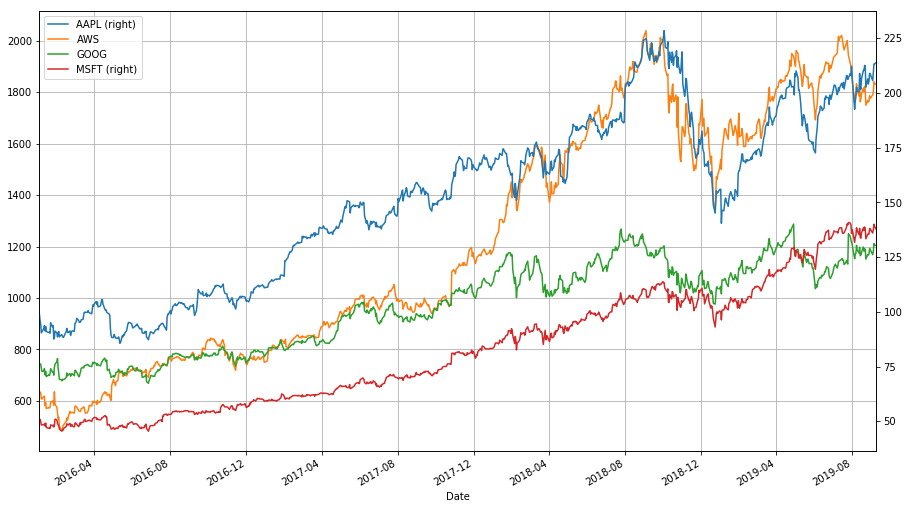

In [97]:
stocks.plot(secondary_y = ["AAPL", "MSFT"], grid = True)


### Setting the parameter

In [126]:
params = {
    "batch_size": 25,  # 20<16<10, 25 was a bust
    "epochs": 10,
    "lr": 0.00010000,
    "time_steps": 60
}

In [127]:
import time
iter_changes = "dropout_layers_0.4_0.4"

OUTPUT_PATH = "outputs/"
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [128]:
import os
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print("Directory created", OUTPUT_PATH)
else:
    print("Directory already exists. Don't override.")

Directory already exists. Don't override.


### Define functions

In [129]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")


def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

### Reading the data

In [130]:

#df_data_2= pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/TSLA.csv',
#                                    parse_dates=['Date'],
#                                    index_col=['Date'])

df_data_2=pd.read_csv(os.environ['DSX_PROJECT_DIR']+'/datasets/TSLA.csv')


In [131]:
df = df_data_2.loc[(df_data_2['Date']>='2017-01-01')]

df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [132]:
df.shape

(675, 7)

In [133]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4846,2019-09-03,147.449997,148.320007,146.000000,146.660004,146.660004,20688000
4847,2019-09-04,148.009995,148.360001,147.179993,147.839996,147.839996,13107500
4848,2019-09-05,149.850006,151.910004,149.369995,150.589996,150.589996,25666700
4849,2019-09-06,150.699997,151.229996,149.830002,149.899994,149.899994,14645900
4850,2019-09-09,150.570007,152.240005,150.059998,151.910004,151.910004,25770900


## Plotting the data

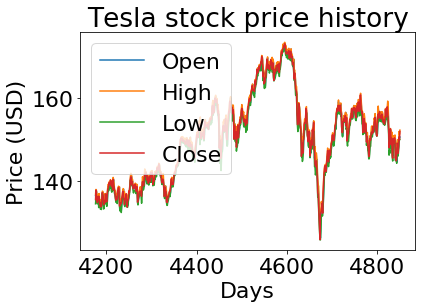

In [134]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title('Tesla stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

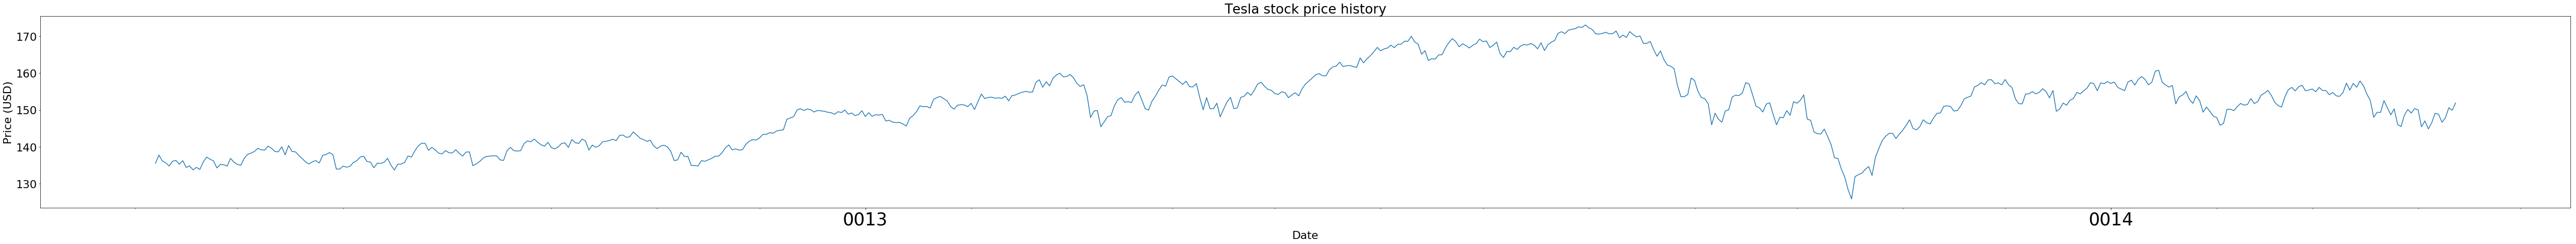

In [135]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')
months_fmt = mdates.DateFormatter('%M')


fig, ax = plt.subplots(figsize=(90, 7))
plt.rcParams.update({'font.size': 22})


# Add the x-axis and the y-axis to the plot
ax.plot(df.index.values,
        df['Close'])


# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Price (USD)",
       title="Tesla stock price history")


ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(35) 



plt.show()

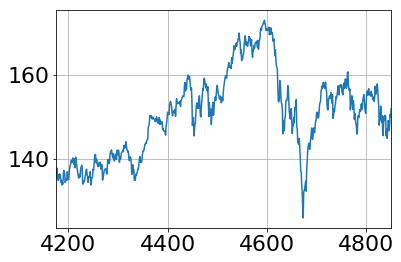

In [136]:
df["Close"].plot(grid = True)


### Checking to see whether we have any NULL value to worry about

In [137]:
# Checking if any null values are present\n"
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Luckyly we do not have any NULL value

### Spliting the data 80/20

In [138]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size: ", len(df_train), len(df_test))

Train and Test size:  540 135


### Normalizing the data
The data is not normalized and the range for each column varies, especially Volume. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. I will use MinMaxScaler from Sci-kit Learn. Also I will convert the DataFrame to ndarray in the process.

In [139]:
from sklearn.preprocessing import MinMaxScaler

train_cols = ["Open","High","Low","Close","Volume"]

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])


In [140]:
x_train.shape

(540, 5)

In [141]:
x_test.shape

(135, 5)

## Converting data to time-series and supervised learning problem


In [142]:
from tqdm import tqdm_notebook

x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)


dim_0 480



length of time-series i/o (480, 60, 5) (480,)


### Building the model using Keras

In [143]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LSTM, Dropout
from keras import optimizers


In [144]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.5, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [145]:
model = None
model = create_model()

In [146]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

dim_0 75



length of time-series i/o (75, 60, 5) (75,)


ValueError: array split does not result in an equal division

In [105]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,"best_model.h5"), monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, verbose=0, mode='auto', cooldown=0, min_lr=0)
csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])

Train on 125 samples, validate on 450 samples
Epoch 1/10
 - 2s - loss: 0.0500 - val_loss: 0.2735

Epoch 00001: val_loss improved from inf to 0.27354, saving model to outputs/best_model.h5
Epoch 2/10
 - 1s - loss: 0.0489 - val_loss: 0.2792

Epoch 00002: val_loss did not improve
Epoch 3/10
 - 1s - loss: 0.0480 - val_loss: 0.2850

Epoch 00003: val_loss did not improve
Epoch 4/10
 - 1s - loss: 0.0470 - val_loss: 0.2923

Epoch 00004: val_loss did not improve
Epoch 5/10
 - 1s - loss: 0.0454 - val_loss: 0.3046

Epoch 00005: val_loss did not improve
Epoch 6/10
 - 1s - loss: 0.0448 - val_loss: 0.3165

Epoch 00006: val_loss did not improve
Epoch 7/10
 - 1s - loss: 0.0430 - val_loss: 0.3331

Epoch 00007: val_loss did not improve
Epoch 8/10
 - 1s - loss: 0.0411 - val_loss: 0.3523

Epoch 00008: val_loss did not improve
Epoch 9/10
 - 1s - loss: 0.0405 - val_loss: 0.3731

Epoch 00009: val_loss did not improve
Epoch 10/10
 - 1s - loss: 0.0385 - val_loss: 0.3967

Epoch 00010: val_loss did not improve


In [106]:
 #save model
import h5py
model.save(filepath="outputs/ge_lstm_model.final")

In [107]:
!ls outputs


best_model.h5
ge_lstm_model.final
training_log_Tue_Sep_10_07:54:00_2019.log
training_log_Tue_Sep_10_09:11:51_2019.log
training_log_Tue_Sep_10_09:23:58_2019.log
training_log_Tue_Sep_10_10:08:52_2019.log
training_log_Tue_Sep_10_10:12:40_2019.log
training_log_Tue_Sep_10_10:17:59_2019.log


### Model evaluation

In [108]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)


print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

ValueError: negative dimensions are not allowed

In [109]:
### load the model if needed
#load model
from keras.models import load_model
saved_model = load_model(filepath="outputs/best_model.h5")
print(saved_model)

In [110]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)


In [85]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])


Error is 0.11954721140005356 (450,) (450,)
[0.937019   0.93703467 0.93704295 0.93704724 0.9370482  0.9370446
 0.9370366  0.93702286 0.93701124 0.93700475 0.93700486 0.9370153
 0.93703467 0.9370581  0.93708336]
[1.18650224 1.1885756  1.18318473 1.1820445  1.18245912 1.17831239
 1.17229951 1.19448486 1.20153434 1.21273072 1.22890319 1.22682982
 1.22745182 1.22268309 1.24725282]


In [86]:
# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

[122.934845 122.936356 122.937164 122.93758  122.93767  122.93732
 122.93654  122.93523  122.9341   122.93347  122.93349  122.934494
 122.936356 122.93863  122.941055]
[147.       147.199997 146.679993 146.570007 146.610001 146.210007
 145.630005 147.770004 148.449997 149.529999 151.089996 150.889999
 150.949997 150.490005 152.860001]


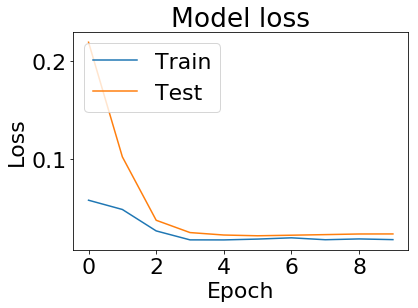

In [87]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join("", 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))


In [88]:
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])


Error is 0.1280218917551648 (450,) (450,)
[0.92633355 0.9263307  0.92632514 0.926317   0.9263071  0.9262938
 0.9262757  0.9262558  0.92623323 0.92621326 0.9261965  0.92618424
 0.9261798  0.9261795  0.92618066]
[1.18650224 1.1885756  1.18318473 1.1820445  1.18245912 1.17831239
 1.17229951 1.19448486 1.20153434 1.21273072 1.22890319 1.22682982
 1.22745182 1.22268309 1.24725282]
[121.90413  121.903854 121.90332  121.90253  121.90158  121.9003
 121.898544 121.89664  121.894455 121.89253  121.890915 121.889725
 121.8893   121.88928  121.88939 ]
[147.       147.199997 146.679993 146.570007 146.610001 146.210007
 145.630005 147.770004 148.449997 149.529999 151.089996 150.889999
 150.949997 150.490005 152.860001]


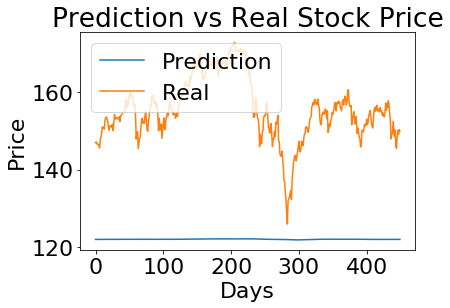

In [89]:
# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
